In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from datetime import datetime

covid_data = pd.read_csv('../input/covid19-dataset/owid-covid-data.csv')
#we only want data from India
#and we only want 2 columns, date,new_cases
covid_data = covid_data[covid_data['location']=='India'][['date','new_cases']]
print(covid_data)
#we replace NaN with 0 in cases and deaths
covid_data.update(covid_data[['new_cases']].fillna(0))
#No more missing values
#now use date as indexs
covid_data['date'] = pd.to_datetime(covid_data.date,format='%Y-%m-%d')
covid_data.index = covid_data['date']
covid_data=covid_data.drop('date', axis=1)
print(covid_data)




             date  new_cases
69678  2020-01-30        1.0
69679  2020-01-31        0.0
69680  2020-02-01        0.0
69681  2020-02-02        1.0
69682  2020-02-03        1.0
...           ...        ...
70439  2022-03-01     7554.0
70440  2022-03-02     6561.0
70441  2022-03-03     6396.0
70442  2022-03-04     5921.0
70443  2022-03-05     5476.0

[766 rows x 2 columns]
            new_cases
date                 
2020-01-30        1.0
2020-01-31        0.0
2020-02-01        0.0
2020-02-02        1.0
2020-02-03        1.0
...               ...
2022-03-01     7554.0
2022-03-02     6561.0
2022-03-03     6396.0
2022-03-04     5921.0
2022-03-05     5476.0

[766 rows x 1 columns]


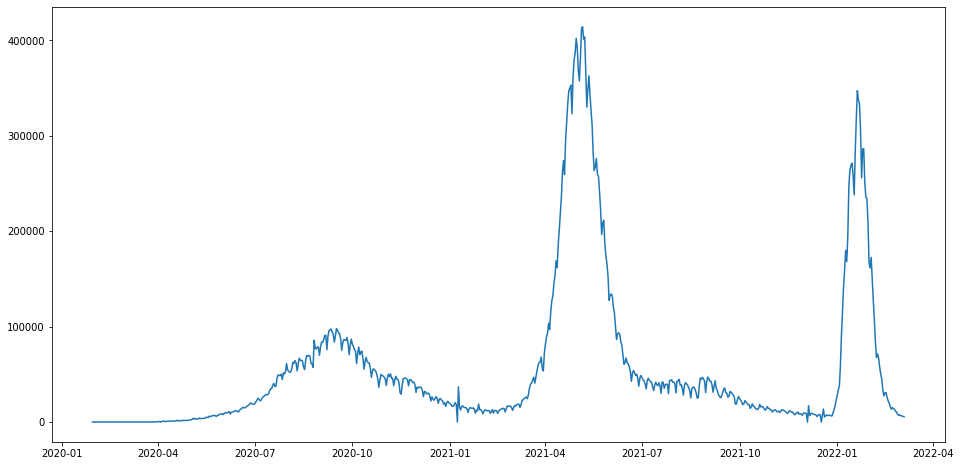

In [54]:


#plt.plot(covid_data['total_cases'], label='Total Cases')

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(covid_data['new_cases'], label='New Cases vs Date')


In [55]:
#In Python, we can directly use the adfuller package from statsmodels
# to see whether the data is stationary at different significance levels. 
# Let us use the ADF test on our step count data 
# to see whether it is stationary or not.
from statsmodels.tsa.stattools import adfuller
result = adfuller(covid_data['new_cases'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))
#As you can see from the result above, 
# the p-value is above 0.05 
# which means my step count data is non-stationary 
# at 1% or 5% significance level. 
#You can also compare the ADF statistic against critical values 
#at different significance levels. 
#The more negative the ADF statistic compared 
# to critical values the more stationary the data.

ADF Statistic: -2.658760
p-value: 0.081450
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [56]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from sklearn.metrics import r2_score



In [57]:
#Make data stationary
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append([value])
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [58]:
look_back=1
newDf = difference(covid_data["new_cases"],1)
newDf[0:10]

array([[-1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

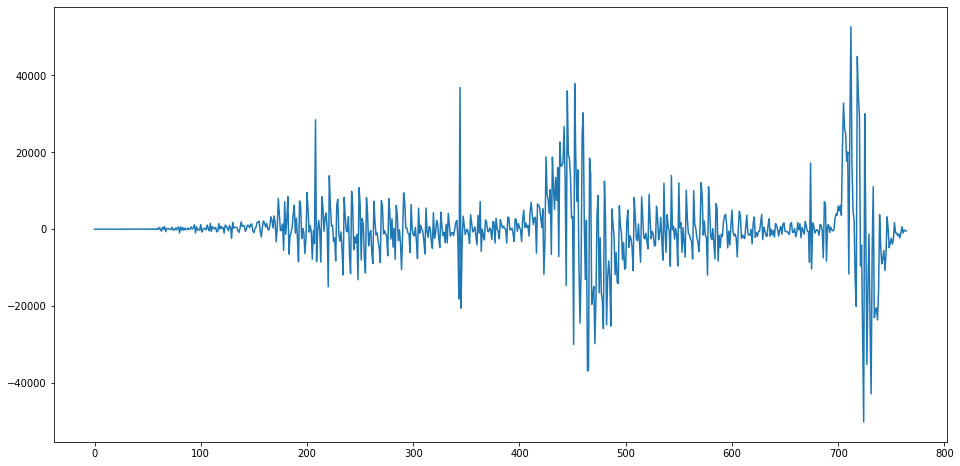

In [59]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(newDf, label='New Cases Difference vs Date')

In [60]:
newResult = adfuller(newDf)
print('ADF Statistic: %f' % newResult[0])
print('p-value: %f' % newResult[1])
print('Critical Values:')
for key, value in newResult[4].items():
 print('\t%s: %.3f' % (key, value))
#As you can see from the result above, 
# the p-value is 0 or nearly 0
# which means my step count data is stationary 
# at 1% or 5% significance level. 
#You can also compare the ADF statistic against critical values 
#at different significance levels. 
#The more negative the ADF statistic compared 
# to critical values the more stationary the data.
# My ADF Statistic change from -2.658760 to -6.586721 after differencing

ADF Statistic: -6.586721
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [61]:
scaler = MinMaxScaler()
# split into train and test sets
train_size = int(len(newDf) * 0.7)
test_size = len(newDf) - train_size
train, test = newDf[0:train_size,:], newDf[train_size:len(newDf),:]
#scale after train-test split to avoid information leak from test
train = scaler.fit_transform(train)
test = scaler.transform(test)
print(len(train), len(test))

535 230


In [62]:
x_train, y_train = create_dataset(train, look_back=1)
x_test, y_test = create_dataset(test, look_back=1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train[0:10])
print(y_train[0:10])

(533, 1)
(533,)
(228, 1)
(228,)
[[0.49335026]
 [0.49336363]
 [0.493377  ]
 [0.49336363]
 [0.49335026]
 [0.49336363]
 [0.49336363]
 [0.49336363]
 [0.49336363]
 [0.49336363]]
[0.49336363 0.493377   0.49336363 0.49335026 0.49336363 0.49336363
 0.49336363 0.49336363 0.49336363 0.49336363]


In [63]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(533, 1, 1)
(533,)
(228, 1, 1)
(228,)


In [64]:
model = Sequential()
#units = 4,  batch_size=1, timesteps = 1, features = 1
model.add(LSTM(4,batch_input_shape=(1, x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(LSTM(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
#output (1,1,4) = (batch_size, timesteps, unit)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 1, 4)                 96        
_________________________________________________________________
lstm_7 (LSTM)                (1, 1)                    24        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    2         
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(x_train, y_train, epochs=16, batch_size=1, verbose=2)

Epoch 1/16
533/533 - 4s - loss: 0.0562
Epoch 2/16
533/533 - 1s - loss: 0.0102
Epoch 3/16
533/533 - 1s - loss: 0.0101
Epoch 4/16
533/533 - 1s - loss: 0.0102
Epoch 5/16
533/533 - 1s - loss: 0.0102
Epoch 6/16
533/533 - 1s - loss: 0.0102
Epoch 7/16
533/533 - 1s - loss: 0.0101
Epoch 8/16
533/533 - 1s - loss: 0.0102
Epoch 9/16
533/533 - 1s - loss: 0.0101
Epoch 10/16
533/533 - 1s - loss: 0.0101
Epoch 11/16
533/533 - 1s - loss: 0.0102
Epoch 12/16
533/533 - 1s - loss: 0.0101
Epoch 13/16
533/533 - 1s - loss: 0.0102
Epoch 14/16
533/533 - 1s - loss: 0.0101
Epoch 15/16
533/533 - 1s - loss: 0.0101
Epoch 16/16
533/533 - 1s - loss: 0.0102


In [66]:
trainPredict = model.predict(x_train,batch_size=1)
testPredict = model.predict(x_test,batch_size=1)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
for i in range(len(trainPredict)):
    trainPredict[i,:] = inverse_difference(covid_data["new_cases"], trainPredict[i,:], len(covid_data["new_cases"])-i)
trainY = scaler.inverse_transform([y_train])

for i in range(len(trainY[0])):
    trainY[0][i] = inverse_difference(covid_data["new_cases"], trainY[0][i], len(covid_data["new_cases"])-i)

testPredict = scaler.inverse_transform(testPredict)
for i in range(len(testPredict)):
    testPredict[i,:] = inverse_difference(covid_data["new_cases"], testPredict[i,:], len(covid_data["new_cases"])-i-len(train))

testY = scaler.inverse_transform([y_test])
for i in range(len(testY[0])):
    testY[0][i] = inverse_difference(covid_data["new_cases"], testY[0][i], len(covid_data["new_cases"])-i-len(train))

for i in range(len(newDf)):
    newDf[i] = inverse_difference(covid_data["new_cases"], newDf[i], len(covid_data["new_cases"])-i)
# calculate root mean squared error
print(trainY.shape, trainPredict.shape)
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

(1, 533) (533, 1)
Train Score: 7503.07 RMSE
Test Score: 10224.09 RMSE


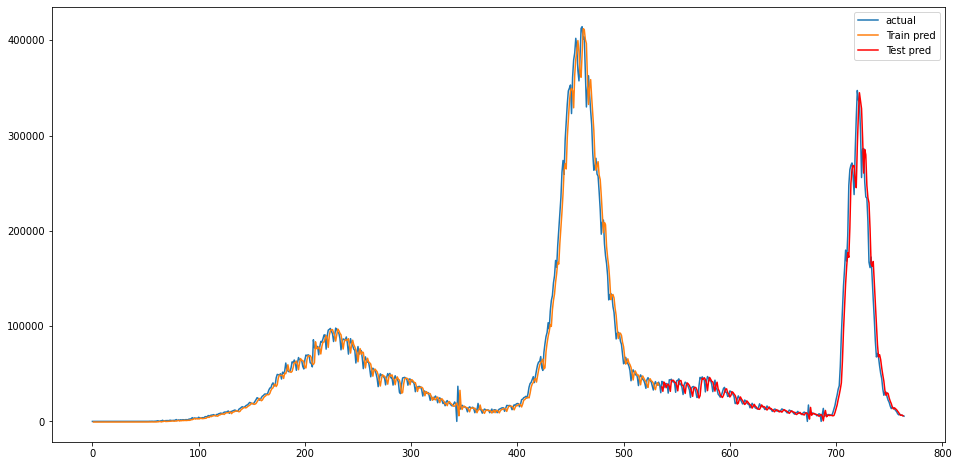

In [67]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(newDf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(newDf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(newDf)-1, :] = testPredict
# plot baseline and predictions
plt.plot(newDf,label = "actual")
plt.plot(trainPredictPlot, label = "Train pred")
plt.plot(testPredictPlot, label = "Test pred", color ="red")
plt.legend()
plt.show()

In [68]:
print("train score: "+str(r2_score(trainY[0], trainPredict[:,0])))
print("test score: "+str(r2_score(testY[0], testPredict[:,0])))


train score: 0.9921846475975487
test score: 0.981538531511235


In [69]:
#30 runs
rmse_train_list = []
rmse_test_list = []
r2_train_list = []
r2_test_list = []
for i in range(30):
    model.fit(x_train, y_train, epochs=16, batch_size=1, verbose=0)
    trainPredict = model.predict(x_train,batch_size=1)
    testPredict = model.predict(x_test,batch_size=1)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    for i in range(len(trainPredict)):
        trainPredict[i,:] = inverse_difference(covid_data["new_cases"], trainPredict[i,:], len(covid_data["new_cases"])-i)
    testPredict = scaler.inverse_transform(testPredict)
    for i in range(len(testPredict)):
        testPredict[i,:] = inverse_difference(covid_data["new_cases"], testPredict[i,:], len(covid_data["new_cases"])-i-len(train))
    # calculate root mean squared error
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    rmse_train_list.append(trainScore)
    testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    rmse_test_list.append(testScore)
    r2_train_list.append(r2_score(trainY[0], trainPredict[:,0]))
    r2_test_list.append(r2_score(testY[0], testPredict[:,0]))
    

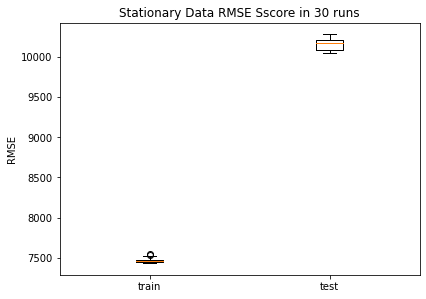

In [70]:

data = [rmse_train_list,rmse_test_list]
fig = plt.figure(figsize =(5, 3.5))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(data)
 # x-axis labels
ax.set_xticklabels(['train', 'test'])
plt.ylabel('RMSE')
plt.title("Stationary Data RMSE Sscore in 30 runs")
# show plot
plt.show()

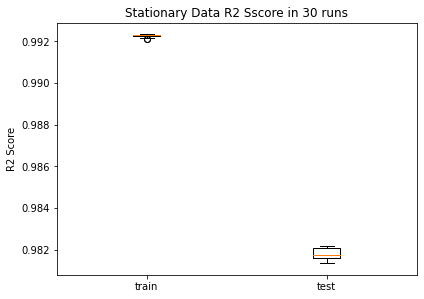

In [71]:
data = [r2_train_list,r2_test_list]
fig = plt.figure(figsize =(5, 3.5))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(data)
 # x-axis labels
ax.set_xticklabels(['train', 'test'])
plt.ylabel('R2 Score')
plt.title("Stationary Data R2 Sscore in 30 runs")
# show plot
plt.show()